# Исследование тональности комментариев для магазина Викишоп

Цель: обучить модель классифицировать комментарии на позитивные и негативные.

Задачи:
1. Загрузить и подготовить данные.
2. Провести лемматизацию и очистку
3. Рассчтитать TfIdf
4. Обучить на полученных данных модели
5. Выбрать лучшую
6. Получить на тестовой выборке значение метрики качества F1 не меньше 0.75.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.probability import FreqDist
from nltk import word_tokenize

from lightgbm import LGBMClassifier

import spacy

import re

from tqdm.notebook import tqdm
tqdm.pandas()

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

In [2]:
RANDOM_STATE = 13

In [3]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\A\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [6]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    text = text.split()
    text = " ".join(text)
    text = text.lower()
    return text

In [7]:
def lem_lem(text):
    text = nlp(text)
    text = " ".join([token.lemma_ for token in text])
    return text

In [4]:
try:

    data = pd.read_csv('.../toxic_comments.csv')
except:

    data = pd.read_csv('/datasets/toxic_comments.csv')

In [9]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [10]:
data.toxic.value_counts()[1] / data.toxic.value_counts()[0]

0.11310497114027364

Данные в переменной, можно действовать.

## Подготовка признаков

In [11]:
data['text'] = data['text'].progress_apply(clear_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
data['text'] = data['text'].progress_apply(lem_lem)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [13]:
corpus = data['text']

In [14]:
corpus.shape

(159292,)

In [15]:
negative = nltk.Text(word_tokenize("".join(data.query('toxic == 1')['text'].values)))
negative = [word for word in negative if word not in stopwords]

In [16]:
freq_dist_neg = FreqDist(negative)

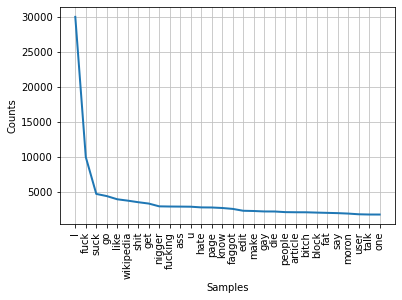

In [17]:
freq_dist_neg.plot(30,cumulative=False);

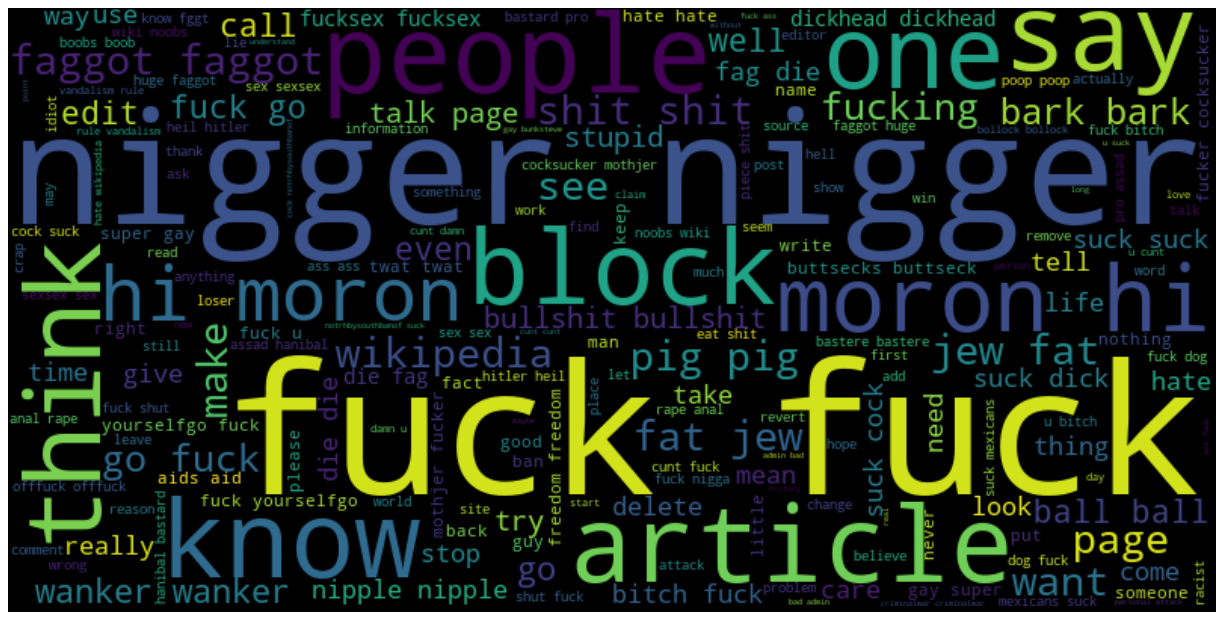

In [18]:
wordcloud_neg = WordCloud(width=800, height=400).generate(' '.join(negative))
figure(figsize=(20, 10), dpi=80)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

In [19]:
positive = nltk.Text(word_tokenize("".join(data.query('toxic == 0')['text'].values)))
positive = [word for word in positive if word not in stopwords]

In [20]:
freq_dist_pos = FreqDist(positive)

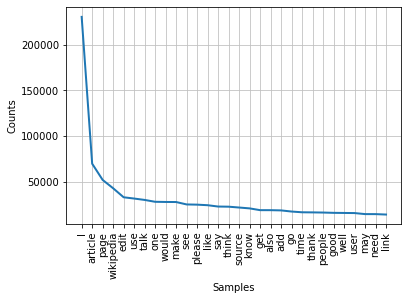

In [21]:
freq_dist_pos.plot(30,cumulative=False);

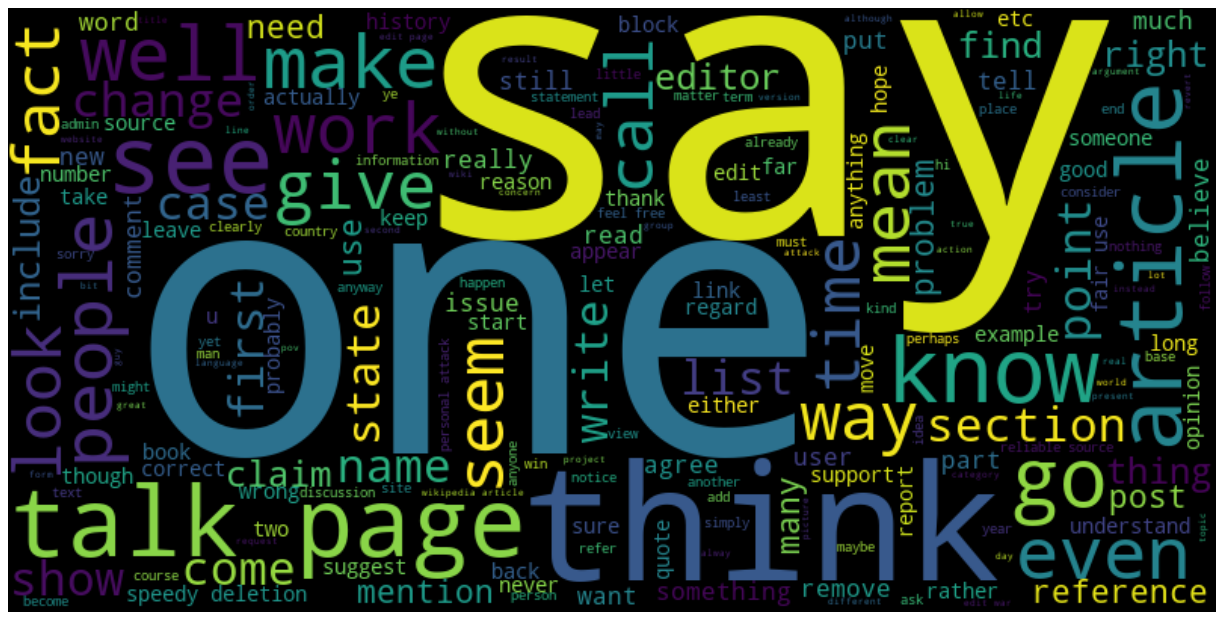

In [22]:
wordcloud_neg = WordCloud(width=800, height=400).generate(' '.join(positive))
figure(figsize=(20, 10), dpi=80)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
ft_train, ft_test, tg_train, tg_test = train_test_split(corpus, data.toxic, stratify=data.toxic, random_state=RANDOM_STATE)

In [24]:
Vectorizer = TfidfVectorizer(stop_words=stopwords)

ft_train = Vectorizer.fit_transform(ft_train) 
ft_test = Vectorizer.transform(ft_test)

Признаки готовы. TfidfVectorizer обучался только на тренировочных данных, валидационные и тестовые данные он уже трансформирует. Можно переходит к обучению.

## Обучение

In [25]:
model_LR = LogisticRegression(penalty='l1',
                              solver='liblinear',
                              random_state=RANDOM_STATE)
GS_LR = GridSearchCV(
    estimator=model_LR,
    param_grid={'C': range(10)},
    cv=5,
    scoring='f1',
    n_jobs=-1,
)

In [26]:
GS_LR.fit(ft_train, tg_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=13,
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': range(0, 10)}, scoring='f1')

In [27]:
GS_LR.best_score_

0.7784424568270673

In [28]:
GS_LR.best_estimator_

LogisticRegression(C=3, penalty='l1', random_state=13, solver='liblinear')

In [29]:
model_GB = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

GS_GB = GridSearchCV(estimator=model_GB,
                     param_grid={'max_depth': [-1, range(10, 15)]},
                     cv=5,
                     scoring='f1',
                     n_jobs=-1,
                     verbose=1)

In [30]:
GS_GB.fit(ft_train, tg_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=13), n_jobs=-1,
             param_grid={'max_depth': [-1, range(10, 15)]}, scoring='f1',
             verbose=1)

In [31]:
GS_GB.best_score_

0.7490596042550102

In [32]:
GS_GB.best_estimator_

LGBMClassifier(random_state=13)

Для данной задачи лучше подходит логистическая регрессия (это я понял пытаясь сделать проект с BERT), поэтому не стал обучать много моделей. Тестовую выборку проверю на логистической регрессии.

## Проверка на тестовой выборке

In [33]:
f1_score(GS_LR.predict(ft_test), tg_test)

0.7862348178137651

Результат достигнут.

## Итоговый вывод

С целью создания модели, классифицирующей комментарии пользователей по тональности были обработаны данные по размеченным ранее комментариям. Подготовлены векторы TfIdf на которых были обучены модели машинного обучения: логистическая регрессия и случайный лес. Метрика качества - F1. Лучшая модель (логистическая регрессия) показала на тестовой выборке уровень выборки 0.78, что удовлетворяет требованиям заказчика.